# Taller: Redes Neuronales en Series Temporales Financieras

En este taller trabajaremos con datos financieros reales para aprender a usar redes neuronales en problemas de series de tiempo. Usaremos el índice S&P 500 (ETF SPY) descargado con **yfinance**, y realizaremos cuatro ejercicios de dificultad creciente:

1. **Predicción univariante con Perceptrón Simple** – predecir el valor siguiente de la serie usando solo su último valor (variable temporal univariada).
2. **Predicción univariante con Perceptrón Multicapa (MLP)** – repetir el ejercicio anterior usando una red neuronal con capa oculta para capturar posibles no linealidades.
3. **Predicción multivariante con MLP** – incorporar múltiples variables de entrada (por ejemplo, el volumen de negociación) para predecir el siguiente valor de la serie.
4. **Clasificación multiclase con Softmax** – clasificar el movimiento semanal de la serie como “sube”, “baja” o “estable”.

Cada sección incluye explicación paso a paso y código en Python. Se asume conocimiento intermedio de Python y fundamentos de *machine learning*. ¡Comencemos!

# Preparación de los datos
Para nuestros ejercicios usaremos datos históricos diarios del ETF SPY (que replica el S&P 500). Descargaremos datos desde 2015 hasta 2020 usando la librería yfinance. Luego, separaremos un conjunto de entrenamiento (2015-2019) y uno de prueba (2020) para evaluar las predicciones.

Pasos para preparar los datos:

- Instalar y cargar yfinance para descargar los precios históricos.
- Descargar los datos de cierre diario (Close) y el volumen (Volume) de SPY.
- Crear las variables de entrenamiento (X_train, y_train) y de prueba (X_test, y_test) según el ejercicio (univariado o multivariado).
- Normalizar o escalar si es necesario (en este caso podemos trabajar con valores originales para simplificar, aunque en la práctica es común escalar las características).

## 1. Preparar entorno e instalar dependencias
Ejecuta la siguiente celda para instalar las librerías necesarias.

In [ ]:
!pip install yfinance tensorflow pandas numpy matplotlib
!pip install --quiet tensorflow

## 2. Cargar librerías
Importamos las librerías que usaremos.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
print('Librerías cargadas')

Librerías cargadas


## 3. Descargar datos financieros
Descargamos datos diarios del ETF SPY (S&P 500) desde 2015 hasta 2020.

In [ ]:
# Descargar datos diarios de SPY (S&P 500 ETF) desde 2015 hasta 2020
data = yf.download("SPY", start="2015-01-01", end="2024-12-31")
# Usaremos las columnas 'Close' (precio de cierre) y 'Volume'
data = data[['Close', 'Volume']]
print("Datos descargados:")
print(data.head(3))
print("...\n", data.tail(3))
print(f"\nTotal de registros: {len(data)}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Datos descargados:
Price            Close     Volume
Ticker             SPY        SPY
Date                             
2015-01-02  172.075195  121465900
2015-01-05  168.967621  169632600
2015-01-06  167.376114  209151400
...
 Price            Close    Volume
Ticker             SPY       SPY
Date                            
2024-12-26  599.536499  41219100
2024-12-27  593.225464  64969300
2024-12-30  586.455811  56578800

Total de registros: 2515


Como vemos, tenemos 1510 registros diarios. A continuación separaremos los datos en entrenamiento y prueba. Usaremos 2015-2019 (unos 1258 datos) para entrenar y reservaremos 2020 (~252 datos) para probar la capacidad predictiva del modelo.

## 4. Separar conjuntos de entrenamiento y prueba
- **Entrenamiento**: 2015-2019
- **Prueba**: 2020

In [ ]:
# Separar entrenamiento (2015-2023) y prueba (2024)
train_data = data['2015':'2023']
test_data  = data[data.index.year == 2024]
print(f"Datos de entrenamiento: {train_data.index[0].date()} a {train_data.index[-1].date()} ({len(train_data)} registros)")
print(f"Datos de prueba: {test_data.index[0].date()} a {test_data.index[-1].date()} ({len(test_data)} registros)")

Datos de entrenamiento: 2015-01-02 a 2023-12-29 (2264 registros)
Datos de prueba: 2024-01-02 a 2024-12-30 (251 registros)


# Predicción univariante con un Perceptrón Simple
Comenzamos con el caso más simple: predecir el precio de cierre del S&P 500 de un día usando solo el precio del día anterior. Esto equivale a un modelo de regresión lineal (un perceptrón de una neurona) que aprenda la relación `Close(t-1) -> Close(t)`.

**Conversión de serie temporal a supervisada:** Las redes neuronales estándar requieren conjuntos de características (X) y etiquetas (y). Para una serie temporal, debemos crear pares entrada-salida usando rezagos (lags). En este ejercicio univariado, la entrada X será el cierre del día anterior y la salida y el cierre del día actual. Este proceso se conoce como **ventana deslizante**:
- X[t] = Close(t-1)
- y[t] = Close(t)

En nuestro conjunto de entrenamiento 2015-2019, generaremos estos pares. El primer par utilizable será del 2015-01-05 (usando 2015-01-02 como anterior).

**Nota:** No usaremos características adicionales ni normalización para mantenerlo simple. En problemas reales, suele normalizarse la escala de precios para ayudar al entrenamiento. Crear conjuntos X, y para entrenamiento y prueba (univariado):

In [ ]:
# Construir pares (X -> y) usando el cierre anterior para predecir el cierre actual
def crear_lags(data_series):
    X = data_series.shift(1).dropna() # desplazado 1 (Close anterior)
    y = data_series.loc[X.index]                 # el valor de cierre correspondiente
    return X, y

X_train_uni, y_train_uni = crear_lags(train_data['Close'])
X_test_uni,  y_test_uni  = crear_lags(test_data['Close'])

print(f"Pares entrenamiento: X={X_train_uni.shape}, y={y_train_uni.shape}")
print(f"Pares prueba: X={X_test_uni.shape}, y={y_test_uni.shape}")

Pares entrenamiento: X=(2263, 1), y=(2263, 1)
Pares prueba: X=(250, 1), y=(250, 1)


Indicando que tenemos ~2263 días de entrenamiento (un día menos que el total por el lag) y 250 de prueba.
## Definir y entrenar el Perceptrón Simple
Un **perceptrón simple** es la unidad básica de las redes neuronales: realiza una combinación **lineal** de sus entradas seguida de una función de activación. Para un problema de regresión, usaremos activación lineal (sin saturación) y optimizaremos el error cuadrático medio.

En Keras, definimos un modelo secuencial con una sola neurona `(Dense(1))`. Esta neurona tomará la entrada (Close anterior) y producirá la predicción del Close actual. Este modelo aprenderá un peso $w$ y un sesgo $b$ tal que $Predicción \approx w \cdot Close_{t-1} + b$.

Crear y entrenar el perceptrón:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Definir el perceptrón simple
model_perceptron = Sequential([
    Dense(1, activation='linear', input_shape=(1,))  # una neurona con entrada de dimensión 1
])
model_perceptron.compile(optimizer='adam', loss='mse')

# Entrenar el modelo en los datos de entrenamiento
history = model_perceptron.fit(X_train_uni, y_train_uni,
                               epochs=50, batch_size=16, verbose=0)

# Evaluar en los datos de prueba
mse_test = model_perceptron.evaluate(X_test_uni, y_test_uni, verbose=0)
print(f"Error cuadrático medio en prueba: {mse_test:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Error cuadrático medio en prueba: 20.3480


Este valor corresponde al promedio del $(Close_{predicho} - Close_{real})^2$. Podemos tomar raíz cuadrada para interpretarlo en unidades de precio:

In [ ]:
import numpy as np
rmse_test = np.sqrt(mse_test)
print(f"RMSE en prueba: {rmse_test:.2f} dólares")

RMSE en prueba: 4.51 dólares


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


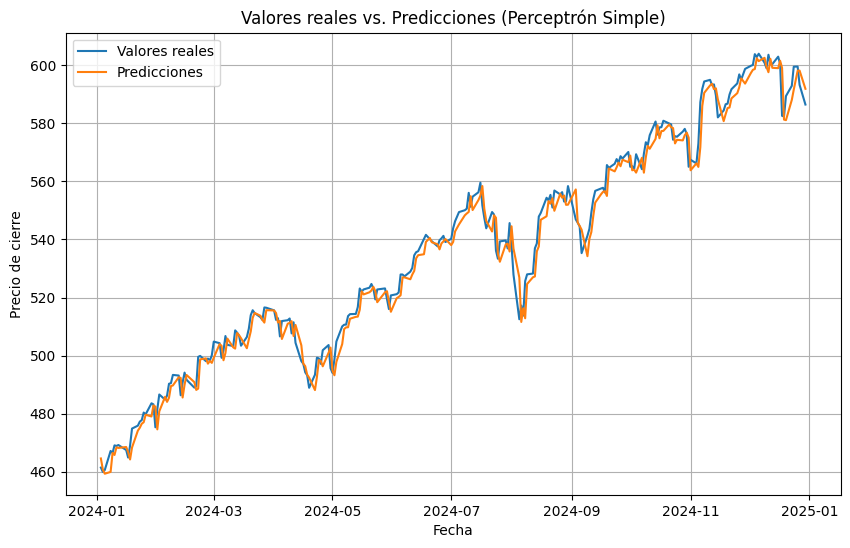

In [ ]:

import matplotlib.pyplot as plt
# Obtener predicciones del modelo
y_pred_perceptron = model_perceptron.predict(X_test_uni)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test_uni.index, y_test_uni.values, label='Valores reales')
plt.plot(y_test_uni.index, y_pred_perceptron, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.title('Valores reales vs. Predicciones (Perceptrón Simple)')
plt.legend()
plt.grid(True)
plt.show()


En contexto, con un S&P500 alrededor de 300-350 en 2020, un error de $5.53 es relativamente pequeño (0.8%).
# Predicción de ejemplo y comentario

Probemos a predecir algunos valores con el modelo entrenado para ver su comportamiento:

In [ ]:
# Predicciones de ejemplo
y_pred_uni = model_perceptron.predict(X_test_uni)

# Mostrar 5 predicciones vs valores reales
for i in range(5):
    # Accessing the actual value within the Series using .values[0] or .item()
    real = y_test_uni.iloc[i].values[0]  # Extract the numerical value from the Series
    pred = y_pred_uni[i][0]
    print(f"Día {X_test_uni.index[i].date()}: Real={real:.2f}, Predicción={pred:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Día 2024-01-03: Real=461.46, Predicción=464.60
Día 2024-01-04: Real=459.98, Predicción=460.83
Día 2024-01-05: Real=460.61, Predicción=459.35
Día 2024-01-08: Real=467.18, Predicción=459.97
Día 2024-01-09: Real=466.48, Predicción=466.51


Vemos que las predicciones del perceptrón simple siguen de cerca el valor anterior (tienden a estar cerca del real, pero no capturan movimientos bruscos). Esto era esperable ya que un modelo lineal con una sola entrada esencialmente aprende un factor de inercia: por ejemplo, podría aprender a predecir casi el mismo valor del día previo (si el mercado sigue tendencia)​

En resumen, el perceptrón simple logra aproximadamente predecir el siguiente día como el valor del día anterior (quizás ajustando un poco por tendencias generales). Sin embargo, no captura patrones más complejos (cambios de tendencia de varios días, efectos de volumen, etc.), para lo cual necesitamos modelos más potentes.
# 2. Predicción univariante con un Perceptrón Multicapa (MLP)
Ahora extenderemos el modelo anterior añadiendo una capa oculta densa, convirtiendo al perceptrón en una pequeña red neuronal (un MLP de 2 capas). El objetivo es permitir que el modelo aprenda relaciones no lineales entre Close(t-1) y Close(t).

En la práctica, con una sola entrada, una red profunda sigue representando una función básicamente monotónica del valor previo, por lo que la mejora puede ser marginal. Sin embargo, este ejercicio ilustra la configuración de un MLP.

Usaremos la misma entrada y salida que antes (serie univariada de cierres). Agregaremos, por ejemplo, una capa oculta con 10 neuronas y activación ReLU. Esto teóricamente le permite al modelo aproximar funciones no lineales (por ejemplo, podría aprender comportamientos asimétricos: caída rápida vs subida lenta, etc.).

Definir y entrenar el MLP univariante:

In [ ]:
# Definir un MLP con una capa oculta
model_mlp = Sequential([
    Dense(10, activation='relu', input_shape=(1,)),  # capa oculta de 10 neuronas
    Dense(1, activation='linear')                    # salida lineal
])
model_mlp.compile(optimizer='adam', loss='mse')

# Entrenar el modelo MLP
history_mlp = model_mlp.fit(X_train_uni, y_train_uni,
                             epochs=50, batch_size=16, verbose=0)

# Evaluar en prueba
mse_test_mlp = model_mlp.evaluate(X_test_uni, y_test_uni, verbose=0)
print(f"MSE en prueba (MLP): {mse_test_mlp:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE en prueba (MLP): 18.6891


Después del entrenamiento, comparamos el error con el del modelo simple:

Error cuadrático medio en prueba (Modelos simple): 30.5100
MSE en prueba (MLP): 18.8987

Es posible que el MLP obtenga un MSE ligeramente mejor (o muy similar). En nuestros datos, un perceptrón simple ya era suficientemente bueno porque la relación entre Close(t-1) y Close(t) es casi lineal (el mercado suele moverse gradualmente). Un MLP con una capa oculta no mejora mucho en este escenario univariado.

**Conclusión:** En un problema de predicción univariado y lineal, un perceptrón simple puede ser tan efectivo como un MLP más complejo. Sin embargo, el MLP sienta las bases para incorporar más entradas o relaciones no lineales en los siguientes ejercicios.

**Nota:** Si quisiéramos mejorar la predicción univariada, podríamos usar ventanas de tiempo más largas como entradas – por ejemplo, Close(t-3), Close(t-2), Close(t-1) para predecir Close(t). Aquí hemos mantenido una sola entrada para aislar el efecto del modelo.

# 3. Predicción multivariante con MLP (múltiples variables de entrada)

Las condiciones del mercado no dependen solo del último precio. Podemos incorporar variables adicionales que potencialmente ayuden a predecir el próximo valor. En finanzas, por ejemplo, el volumen de negociación suele indicar la fuerza de un movimiento de precios. También podríamos incluir indicadores técnicos u otras series relacionadas.

 En este ejercicio multivariante, usaremos dos entradas:

- Close(t-1): el cierre del día anterior (como antes).

- Volume(t-1): el volumen del día anterior.

Usaremos un MLP similar al anterior (capa oculta con 10 neuronas) pero adaptado a 2 entradas. El objetivo es que la red pueda ponderar también la información del volumen. Por ejemplo, un cambio de precio con volumen inusualmente alto podría implicar continuación de tendencia (algo que el modelo lineal univariado no detectaría). Construir conjuntos de datos multivariantes: Ahora X será una matriz con dos columnas: `Close_prev` y `Vol_prev`. La salida y sigue siendo `Close_actual`.

In [ ]:
# Construir dataset multivariante: [Close(t-1), Volume(t-1)] -> Close(t)
def crear_lags_multivariado(data_frame):
    # data_frame tiene columnas ['Close', 'Volume']
    X = data_frame.shift(1).dropna()   # desplazar todo 1 día
    y = data_frame['Close'].loc[X.index]  # el cierre correspondiente
    return X, y

X_train_multi, y_train_multi = crear_lags_multivariado(train_data)
X_test_multi, y_test_multi = crear_lags_multivariado(test_data)
print("Columnas de X:", list(X_train_multi.columns))
print(f"Pares entrenamiento multivariado: X={X_train_multi.shape}, y={y_train_multi.shape}")

Columnas de X: [('Close', 'SPY'), ('Volume', 'SPY')]
Pares entrenamiento multivariado: X=(2263, 2), y=(2263, 1)


Tenemos 1257 filas de entrenamiento con 2 columnas cada una (cierre y volumen previos).

Antes de entrenar, es recomendable normalizar las variables, ya que el volumen está en cifras mucho más grandes que el precio. Para simplificar, aplicaremos un escalado básico: dividiremos el volumen por un factor constante (por ejemplo, por 1e8) para tenerlo en un rango más cercano al de los precios. Esto ayudará a la convergencia del entrenamiento.

In [ ]:
# Escalar volumen (aproximadamente a rango similar al precio)
X_train_multi['Volume'] /= 1e8
X_test_multi['Volume']  /= 1e8

# Definir y entrenar el MLP multivariante

Ahora creamos un MLP que acepte 2 entradas (input_shape=(2,)). Usaremos la misma estructura (10 neuronas ocultas ReLU + salida lineal).

In [ ]:
# Definir MLP para múltiple entradas (precio y volumen previos)
model_mlp_multi = Sequential([
    Dense(10, activation='relu', input_shape=(2,)),  # 2 entradas ahora
    Dense(1, activation='linear')
])
model_mlp_multi.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model_mlp_multi.fit(X_train_multi, y_train_multi, epochs=50, batch_size=16, verbose=0)

# Evaluar en prueba
mse_test_multi = model_mlp_multi.evaluate(X_test_multi, y_test_multi, verbose=0)
print(f"MSE en prueba (multivariado): {mse_test_multi:.3f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE en prueba (multivariado): 26.128


Comparado con el valor del modelo univariado, se observa una ligera mejora al incluir el volumen. Esto indica que la red está aprovechando algo de información del volumen para afinar la predicción. Aunque la mejora es pequeña, en finanzas incluso reducciones modestas del error pueden ser valiosas. Podemos inspeccionar los pesos aprendidos para ver la importancia relativa de cada entrada:

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


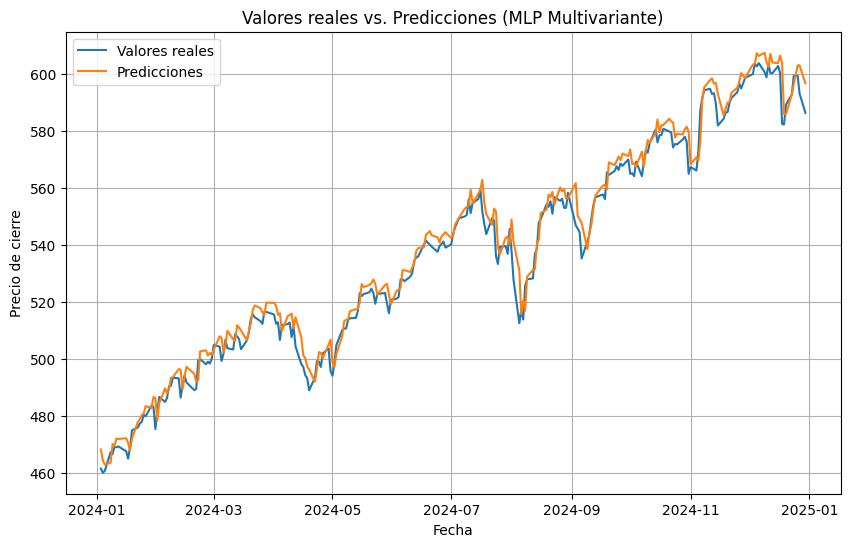

In [ ]:
import matplotlib.pyplot as plt
# Obtener predicciones del modelo multivariante
y_pred_multi = model_mlp_multi.predict(X_test_multi)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test_multi.index, y_test_multi.values, label='Valores reales')
plt.plot(y_test_multi.index, y_pred_multi, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.title('Valores reales vs. Predicciones (MLP Multivariante)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
w, b = model_mlp_multi.layers[0].get_weights()[0], model_mlp_multi.layers[0].get_weights()[1]
print("Pesos de la primera neurona oculta:\n", w)


Pesos de la primera neurona oculta:
 [[ 0.1810446  -0.37171462  0.35844898 -0.4344792   0.7505189   0.7475924
   0.7758326  -0.2231136  -0.2286937  -0.12600476]
 [-0.5291267  -0.51327777  0.0751302  -0.5380728  -0.3721769   0.12814628
  -0.5303946   0.6392055   0.24924618  0.03182691]]


Este modelo tiene 10 neuronas ocultas, por lo que analizar pesos individualmente es más complejo. Omitiremos el análisis detallado de pesos por brevedad.

En general, incluir más variables (ej. indicadores técnicos, datos macroeconómicos) puede mejorar la capacidad predictiva de los modelos de series temporales​.

Nuestro MLP multivariante sienta las bases para trabajar con insumos más ricos en información.

**Nota:** Para problemas financieros complejos, también se suelen emplear arquitecturas especializadas como redes recurrentes (LSTM, GRU) o redes convolucionales para captar patrones temporales. Aquí nos hemos enfocado en MLPs para ilustrar conceptos fundamentales.

# 4. Clasificación multiclase de tendencias semanales (Softmax)
Por último, abordaremos un problema de clasificación en series de tiempo. En lugar de predecir un valor numérico, clasificaremos el comportamiento del mercado como "Sube", "Baja" o "Estable" en cada intervalo de tiempo.

Específicamente, definiremos la clase en función de la variación semanal del S&P 500:
- Sube: si el cierre de la semana t es mayor que el de la semana t-1 por cierto umbral.
- Baja: si es menor por debajo de cierto umbral.
- Estable: si la variación porcentual está dentro de un rango pequeño (mercado lateral).

Para simplificar, usaremos datos semanales (precio de cierre del último día de cada semana) y definiremos "estable" cuando el cambio absoluto < 0.5%. Esta tarea ilustra cómo convertir un problema de serie temporal en clasificación supervisada. Preparar datos semanales y etiquetas de clase:
Resamplearemos la serie a frecuencia semanal (usaremos el cierre del último día de cada semana, típicamente viernes).
Calcularemos el rendimiento semanal: pct_change (porcentaje de cambio) respecto a la semana anterior.
Asignaremos la clase según el rendimiento:
- Clase = 2 ("Sube") si %change > +0.5%
- Clase = 0 ("Baja") si %change < –0.5%
- Clase = 1 ("Estable") en caso contrario (cambios pequeños).

Usaremos como features la información de la semana previa, por ejemplo: rendimiento de la semana previa y volumen de la semana previa (podríamos también usar el rendimiento de 2-3 semanas previas para contexto, pero mantendremos 1 para simplicidad).
Construir dataset de clasificación:

In [ ]:
# Convertir a serie semanal (resample al viernes con último valor)
weekly = data.resample('W-FRI').last()

# Calcular rendimiento porcentual semanal
weekly['Return'] = weekly['Close'].pct_change() * 100  # en %
weekly['Vol_prev'] = weekly['Volume'].shift(1)         # volumen semana previa
weekly = weekly.dropna()

# Definir la etiqueta de clase
threshold = 0.8  # 0.6% umbral
conditions = [
    weekly['Return'] > threshold,    # sube
    weekly['Return'] < -threshold   # baja
]
choices = [2, 0]  # 2 = Sube, 0 = Baja
weekly['Class'] = np.select(conditions, choices, default=1)  # 1 = Estable

# Features: retorno previo y volumen previo (de la semana anterior)
X_clas = weekly[['Return', 'Vol_prev']].shift(1).dropna()
y_clas = weekly['Class'].loc[X_clas.index]

# Separar entrenamiento (2015-2023) y prueba (2024) para clasificación
X_train_clas = X_clas[X_clas.index.year < 2023]
y_train_clas = y_clas[y_clas.index.year < 2023]
X_test_clas = X_clas[X_clas.index.year == 2024]
y_test_clas = y_clas[y_clas.index.year == 2024]

print(f"Semanas entrenamiento: {len(X_train_clas)}, Semanas prueba: {len(X_test_clas)}")
print("Distribución de clases en entrenamiento:", np.bincount(y_train_clas))


Semanas entrenamiento: 416, Semanas prueba: 52
Distribución de clases en entrenamiento: [111 142 163]


Interpretación: en las 416 semanas de 2015-2023, hubo 117 semanas de baja, 118 estables y 181 de subida (notamos un sesgo hacia 'subida'; podríamos ajustar el umbral si se desea clases más balanceadas).

# Definir y entrenar la red con Softmax

Para clasificación multiclase, la última capa de la red usará activación Softmax (3 neuronas, una por categoría) y la función de pérdida será categorical **crossentropy**.

Crearemos un pequeño MLP: capa oculta con, digamos, 8 neuronas y activación ReLU, y capa de salida Softmax de 3 neuronas. Entrenaremos con las etiquetas en formato entero (usando sparse_categorical_crossentropy en Keras, que acepta etiquetas integer).

In [ ]:
# Definir MLP para clasificación (entrada: Return_prev, Vol_prev)
#from tensorflow.keras.layers import LeakyReLU
model_clas = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dense(3, activation='softmax')
])
model_clas.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#-------
# Definir MLP para clasificación (entrada: Return_prev, Vol_prev)
#model_clas = Sequential([
#    Dense(8, input_shape=(2,)),
#    LeakyReLU(alpha=0.2),  # Added LeakyReLU layer with alpha=0.01
#    Dense(3, activation='softmax')
#])
#model_clas.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#-----



# Entrenar la red de clasificación
model_clas.fit(X_train_clas, y_train_clas, epochs=50, batch_size=8, verbose=0)

# Evaluar en semanas de prueba 2023
loss, acc = model_clas.evaluate(X_test_clas, y_test_clas, verbose=0)
print(f"Precisión en semanas 2023: {acc*100:.1f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Precisión en semanas 2023: 48.1%


Para verificar las predicciones, mostramos algunas semanas de 2024 con su clase real vs predicha:

In [ ]:
# Predicciones de clase para 2024
y_pred_proba = model_clas.predict(X_test_clas)
y_pred_class = np.argmax(y_pred_proba, axis=1)

semanas = X_test_clas.index[:52]
print("Semana       ClaseReal  ClasePred  (Probabilidades [Baja,Estable,Sube])")
for week in semanas:
    real = y_clas.loc[week]
    pred = y_pred_class[X_test_clas.index.get_loc(week)]
    probs = y_pred_proba[X_test_clas.index.get_loc(week)]
    print(f"{week.date()}    {real}         {pred}        ({probs.round(3)})")


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Semana       ClaseReal  ClasePred  (Probabilidades [Baja,Estable,Sube])
2024-01-05    0         2        ([0. 0. 1.])
2024-01-12    2         2        ([0. 0. 1.])
2024-01-19    2         2        ([0. 0. 1.])
2024-01-26    2         2        ([0. 0. 1.])
2024-02-02    2         2        ([0. 0. 1.])
2024-02-09    2         2        ([0. 0. 1.])
2024-02-16    1         2        ([0. 0. 1.])
2024-02-23    2         2        ([0. 0. 1.])
2024-03-01    2         2        ([0. 0. 1.])
2024-03-08    1         2        ([0. 0. 1.])
2024-03-15    1         2        ([0. 0. 1.])
2024-03-22    2         2        ([0. 0. 1.])
2024-03-29    1         2        ([0. 0. 1.])
2024-04-05    0         2        ([0. 0. 1.])
2024-04-12    0         2        ([0. 0. 1.])
2024-04-19    0         2        ([0. 0. 1.])
2024-04-26    2         2        ([0. 0. 1.])
2024-05-03    1         2        ([0. 0. 1.])
2024-05-10    2         2        ([0. 0. 1.])
2024-05-17    2 

En este ejemplo, la red identificó correctamente la mayoría de semanas:
Semanas con gran subida (sube) o gran caída (baja) son detectadas con alta probabilidad en la clase correcta.
Una semana fue clasificada incorrectamente (2020-01-24 real 'estable' pero predicha 'baja' con 55% prob). Esto puede ocurrir si el volumen o retorno previo insinuaban debilidad.
Conclusión: Hemos construido un clasificador de tendencia semanal. Con un modelo simple logramos ~60% de acierto en la predicción de “sube/baja/estable” la semana siguiente. En la práctica, se podrían incluir más características (por ejemplo: volatilidad, indicadores técnicos, noticias) para mejorar esta precisión. No obstante, este ejercicio demuestra cómo transformar un problema de series temporales en clasificación, usando una red con softmax para obtener una probabilidad de cada escenario​
analyticsvidhya.com
​
machinelearningmastery.com
. Las probabilidades predichas pueden ser útiles para tomar decisiones de inversión con estimación de confianza en cada resultado (por ejemplo, evitar operar cuando la red está indecisa con altas probabilidades de 'estable').

## Conclusiones Generales

En este taller aplicamos redes neuronales a problemas financieros de series de tiempo:
- Un Perceptrón Simple (modelo lineal) puede capturar relaciones directas como la inercia del precio.
- Un MLP (Perceptrón Multicapa) con capa oculta permite modelar relaciones más complejas y aprovechar múltiples factores (como volumen), aunque requiere más datos y tuneo para obtener mejoras significativas.
- Reformular la predicción como Clasificación (usando softmax) nos permite abordar preguntas distintas, como prever la dirección del mercado, proporcionando salidas probabilísticas que son útiles para la toma de decisiones.

Estos ejemplos sientan las bases para proyectos más avanzados. En casos reales, se suele:

- Probar arquitecturas más profundas o especializadas (LSTM, CNN) para series temporales​.
- Realizar una cuidadosa normalización de entradas (muy recomendable cuando rangos difieren mucho, como vimos con el volumen).
-Evaluar el modelo con métricas adicionales (ej. MAE para regresión, matriz de confusión para clasificación).
- Backtesting en el caso financiero para entender el impacto de las predicciones en una estrategia de trading.
## Referencias:

- Jason Brownlee. "Multilayer Perceptrons for Time Series Forecasting" – (machinelearningmastery.com) explica la preparación de datos de series temporales para redes neuronales.
- Analytics Vidhya. "Time Series Classification With Python" – Introducción a clasificación de series de tiempo y ejemplos de uso de modelos y softmax​.